In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors
from econml.dml import LinearDML
import statsmodels.api as sm
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output (e.g., convergence warnings in high-dim logistic reg)
warnings.filterwarnings('ignore')

## Data Generation in rare disease setting

In [3]:
def generate_bin_data(n=500, p=100, seed=123):
    np.random.seed(seed)
    
    # 1. Generate Covariates (100 variables)
    X = np.random.normal(0, 1, size=(n, p))
    
    # 2. Define the &quot;True&quot; Confounding Mechanism (The Nuisance Function)
    # Only the first 5 variables (indices 0-4) actually matter.
    # Interaction: X0 * X1
    # Non-linear: X2 squared
    # Linear: X3, X4
    nuisance_term = 0.5 * X[:,0] * X[:,1] + 0.4 * (X[:,2]**2) + 0.3 * X[:,3] + 0.2 * X[:,4]
    # 3. Treatment Assignment (Propensity)
    # P(T=1 | X) depends on the nuisance term
    logit_p = -0.5 + nuisance_term
    prob_t = 1 / (1 + np.exp(-logit_p))
    T = np.random.binomial(1, prob_t)
    # 4. Outcome Generate
    # True Causal Effect is ~15% Risk Difference (calculated via simulation below)
    
    # Base Log-Odds (without treatment)
    logit_y_base = -1.5 + nuisance_term
    
    # To get the Ground Truth Risk Difference, we simulate the counterfactuals:
    # What if everyone was treated?
    p1_true = 1 / (1 + np.exp(-(logit_y_base + 0.8 * 1))) 
    # What if everyone was untreated?
    p0_true = 1 / (1 + np.exp(-(logit_y_base + 0.8 * 0)))
    
    true_ate = np.mean(p1_true - p0_true)
    
    # Generate Observed Binary Outcome
    # We add the treatment effect (0.8 log odds) to the base
    logit_y_observed = logit_y_base + 0.8 * T
    prob_y_observed = 1 / (1 + np.exp(-logit_y_observed))
    Y = np.random.binomial(1, prob_y_observed)
    Y = Y.astype(int)
    
    return X, T, Y, true_ate


## Model Setup

In [4]:
class CausalEstimators:

# A helper class to run various causal inference methods:
# 1. Naive (Unadjusted Difference in Means)
# 2. Regression Adjustment (Linear/Logistic)
# 3. IPTW (Inverse Probability of Treatment Weighting)
# 4. PSM (Propensity Score Matching 1:1)
# 5. DML (Double Machine Learning)

    def __init__(self, X, T, Y, outcome_type= 'continuous'):
        self.X = X
        self.T = T
        self.Y = Y
        self.outcome_type = outcome_type
        # Create a DataFrame for easier handling in naive methods
        self.df = pd.DataFrame(X)
        self.df['T'] = T
        self.df['Y'] = Y
    def run_naive(self):
    
        treated = self.df[self.df['T'] == 1]['Y'].mean()
        control = self.df[self.df['T'] == 0]['Y'].mean()
        return treated - control

    def run_regression_adjustment(self):
        features = np.column_stack((self.T, self.X))
        # Logistic Regression for binary outcome
        # We suppressed l2 penalty (default) to micic conventional logistic model (N=500, P=100)
        model = LogisticRegression(penalty = None,solver='lbfgs', max_iter=2000) 
        model.fit(features, self.Y)
        
        # --- Marginal Effects (Risk Difference) ---
        # 1. Create a dataset where EVERYONE is treated (T=1)
        X_treated = np.column_stack((np.ones(len(self.X)), self.X))
        # 2. Create a dataset where EVERYONE is control (T=0)
        X_control = np.column_stack((np.zeros(len(self.X)), self.X))
        
        # 3. Predict probabilities for both counterfactuals
        p1 = model.predict_proba(X_treated)[:, 1]
        p0 = model.predict_proba(X_control)[:, 1]
        # p1 = model.predict(X_treated)[:, 1]
        # p0 = model.predict(X_control)[:, 1]
        
        # 4. Average difference is the Average Treatment Effect (Risk Difference)
        return np.mean(p1 - p0)


    def run_iptw(self):
        # Estimate Propensity Scores
        ps_model = LogisticRegression(penalty = None,solver='lbfgs', max_iter=2000)
        ps_model.fit(self.X, self.T)
        ps = ps_model.predict_proba(self.X)[:, 1]
        
        # Clip to prevent division by zero or extreme weights
        ps = np.clip(ps, 0.05, 0.95)
        
        # Calculate weights: 1/PS for treated, 1/(1-PS) for control
        weights = np.where(self.T == 1, 1/ps, 1/(1-ps))
        
        # Optional: Check for extreme weights (can add weight truncation)
        # Uncomment if you want to truncate at 99th percentile
        # weight_cap = np.percentile(weights, 99)
        # weights = np.minimum(weights, weight_cap)
        
        # Safety check: ensure both groups exist
        treated_mask = (self.T == 1)
        control_mask = (self.T == 0)
        
        if not np.any(treated_mask) or not np.any(control_mask):
            return np.nan
        
        # Weighted Difference in Means (Risk Difference)
        weighted_mean_1 = np.average(self.Y[treated_mask], weights=weights[treated_mask])
        weighted_mean_0 = np.average(self.Y[control_mask], weights=weights[control_mask])
        
        return weighted_mean_1 - weighted_mean_0


    def run_psm(self):
        # 1. Estimate Propensity Scores
        ps_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=2000)
        ps_model.fit(self.X, self.T)
        ps = ps_model.predict_proba(self.X)[:, 1]
        
        treated_idx = np.where(self.T == 1)[0]
        control_idx = np.where(self.T == 0)[0]
        
        # Safety check for separation
        if len(control_idx) == 0 or len(treated_idx) == 0:
            return np.nan
        
        # 2. Setup for Matching Without Replacement
        caliper = 0.2 * np.std(ps)
        available_control_indices = list(control_idx)
        matched_treated_idx = []
        matched_control_idx = []
    
        # Optional: Shuffle treated indices to avoid order bias
        # np.random.shuffle(treated_idx)
    
        for t_idx in treated_idx:
            if not available_control_indices:
                break
                
            # Get PS for current treated unit and available controls
            t_ps = ps[t_idx].reshape(-1, 1)
            current_control_ps = ps[available_control_indices].reshape(-1, 1)
            
            # Find nearest neighbor in the remaining pool
            nbrs = NearestNeighbors(n_neighbors=1).fit(current_control_ps)
            dist, indices = nbrs.kneighbors(t_ps)
            
            distance = dist.flatten()[0]
            match_idx_in_pool = indices.flatten()[0]
            
            # 3. Apply Caliper Check
            if distance <= caliper:
                # Get the actual index from the original dataset
                actual_c_idx = available_control_indices[match_idx_in_pool]
                
                matched_treated_idx.append(t_idx)
                matched_control_idx.append(actual_c_idx)
                
                # REMOVE the control unit so it cannot be reused
                available_control_indices.pop(match_idx_in_pool)
    
        # Check if we found any valid matches
        if len(matched_treated_idx) == 0:
            return np.nan
    
        # Convert to arrays for final indexing
        matched_treated_idx = np.array(matched_treated_idx)
        matched_control_idx = np.array(matched_control_idx)
    
        # 4. Calculate SMD for balance check
        X_treated = self.X[matched_treated_idx]
        X_matched_control = self.X[matched_control_idx]
        
        mean_diff = np.mean(X_treated, axis=0) - np.mean(X_matched_control, axis=0)
        pooled_std = np.sqrt((np.var(X_treated, axis=0) + np.var(X_matched_control, axis=0)) / 2)
        pooled_std = np.where(pooled_std == 0, 1, pooled_std)
        smd = np.abs(mean_diff / pooled_std)
        
        # Return null if more than 10% of variables have poor balance (SMD > 0.25)
        if np.mean(smd > 0.25) > 0.1:
            return np.nan
        
        # 5. Average Treatment Effect on the Treated (ATT)
        return np.mean(self.Y[matched_treated_idx]) - np.mean(self.Y[matched_control_idx])
    
    def run_dml(self):
        # Use shallow trees (depth 2) to prevent overfitting on small N=500
        y_model = GradientBoostingClassifier(n_estimators=250, max_depth=3, random_state=42)
        t_model = GradientBoostingClassifier(n_estimators=250, max_depth=3, random_state=42)
    
        # Set cv=3 for small sample size (5-fold might be too thin)
        est = LinearDML(model_y=y_model,
                        model_t=t_model,
                        discrete_outcome = True,
                        discrete_treatment=True,
                        cv=3,
                        random_state=42)
        est.fit(self.Y, self.T, X=self.X)
        # Return Average Treatment Effect
        return est.effect(self.X).mean()


## Results summary

In [5]:
def run_simulation(n_epochs=100):
    # 1. Initialize a list to store results
    results_list = []

    print(f"Starting simulation with {n_epochs} epochs...")

    for epoch in tqdm(range(n_epochs)):
        # --- 1. CONTINUOUS OUTCOME ---
        X, T, Y, true_eff = generate_bin_data(n=500, p=100, seed = epoch)
        sim = CausalEstimators(X, T, Y, outcome_type='continuous')
                
        # 3. Apply your 5 different methods
        # Replace these with your actual function calls (e.g., DML, PSM, etc.)
        
        # Method 1: Naive (Unadjusted)
        res_m1 = sim.run_naive()
        
        # Method 2: Regression (Linear)
        res_m2 = sim.run_regression_adjustment()
        
        # Method 3: IPTW (Logistic PS)
        res_m3 = sim.run_iptw()
        
        # Method 4: PSM (1:1 Nearest Neighbor)
        res_m4 = sim.run_psm()
        
        # Method 5: DML (Gradient Boosting)
        res_m5 = sim.run_dml()

        # 4. Record results for each method in a dictionary
        # We store them as separate rows to make it "tidy" (Long Format)
        methods = {
            "Naive (Unadjusted)": res_m1,
            "Regression (Logistic):": res_m2,
            "IPTW (Logistic PS)": res_m3,
            "PSM (1:1 Nearest Neighbor)": res_m4,
            "DML (Gradient Boosting)": res_m5
        }

        for method_name, value in methods.items():
            results_list.append({
                "epoch": epoch,
                "method": method_name,
                "estimate": value,
                "bias": abs(value - true_eff), # You can add metrics here
            })

    # 5. Convert the list of dictionaries to a pandas DataFrame
    df_results = pd.DataFrame(results_list)
    
    return df_results


In [6]:
# Execute main group
df = run_simulation(n_epochs=1000)

Starting simulation with 1000 epochs...


100%|██████████| 1000/1000 [2:54:39<00:00, 10.48s/it] 


In [7]:
# Quick summary of mean estimates results across methods for main simulation
# 2. Group and calculate mean, std, and quantiles
summary = df.groupby('method')['estimate'].agg(
    mean='mean',
    std='std',
    ci_2_5=lambda x: x.quantile(0.025),
    ci_97_5=lambda x: x.quantile(0.975)
).reset_index()

# 3. Create a formatted CI column for a cleaner table
summary['95% CI'] = summary.apply(
    lambda x: f"[{x['ci_2_5']:.3f}, {x['ci_97_5']:.3f}]", axis=1
)

print("\nSimulation Estimates Summary:")
print(summary[['method', 'mean', 'std', '95% CI']])


Simulation Estimates Summary:
                       method      mean       std          95% CI
0     DML (Gradient Boosting)  0.192585  0.052428  [0.087, 0.293]
1          IPTW (Logistic PS)  0.250797  0.052274  [0.153, 0.358]
2          Naive (Unadjusted)  0.269620  0.041328  [0.191, 0.348]
3  PSM (1:1 Nearest Neighbor)  0.250099  0.053947  [0.146, 0.354]
4      Regression (Logistic):  0.253136  0.048229  [0.161, 0.351]


In [8]:
# Quick summary of mean bias results across methods for main simulation
summary = df.groupby('method')['bias'].agg(
    mean='mean',
    std='std',
    ci_2_5=lambda x: x.quantile(0.025),
    ci_97_5=lambda x: x.quantile(0.975)
).reset_index()

# 3. Create a formatted CI column for a cleaner table
summary['95% CI'] = summary.apply(
    lambda x: f"[{x['ci_2_5']:.3f}, {x['ci_97_5']:.3f}]", axis=1
)

print("\nSimulation Estimates Summary:")
print(summary[['method', 'mean', 'std', '95% CI']])


Simulation Estimates Summary:
                       method      mean       std          95% CI
0     DML (Gradient Boosting)  0.050432  0.037852  [0.002, 0.137]
1          IPTW (Logistic PS)  0.094318  0.050198  [0.005, 0.200]
2          Naive (Unadjusted)  0.111963  0.041464  [0.032, 0.191]
3  PSM (1:1 Nearest Neighbor)  0.094278  0.050801  [0.006, 0.198]
4      Regression (Logistic):  0.096157  0.046961  [0.010, 0.192]


In [9]:
import re
# Function to remove content in parentheses
def clean_method(text):
    if isinstance(text, str):
        # Remove anything in parentheses
        return re.sub(r'\(.*?\)', '', text).strip()
    return text
# Apply the cleaning
df['method'] = df['method'].apply(clean_method)

# Remove any trailing colons if they exist (seen in the snippet "Regression (Linear):")
df['method'] = df['method'].str.rstrip(':').str.strip()

In [10]:
df.to_csv('output——bin_2.csv', index=False)

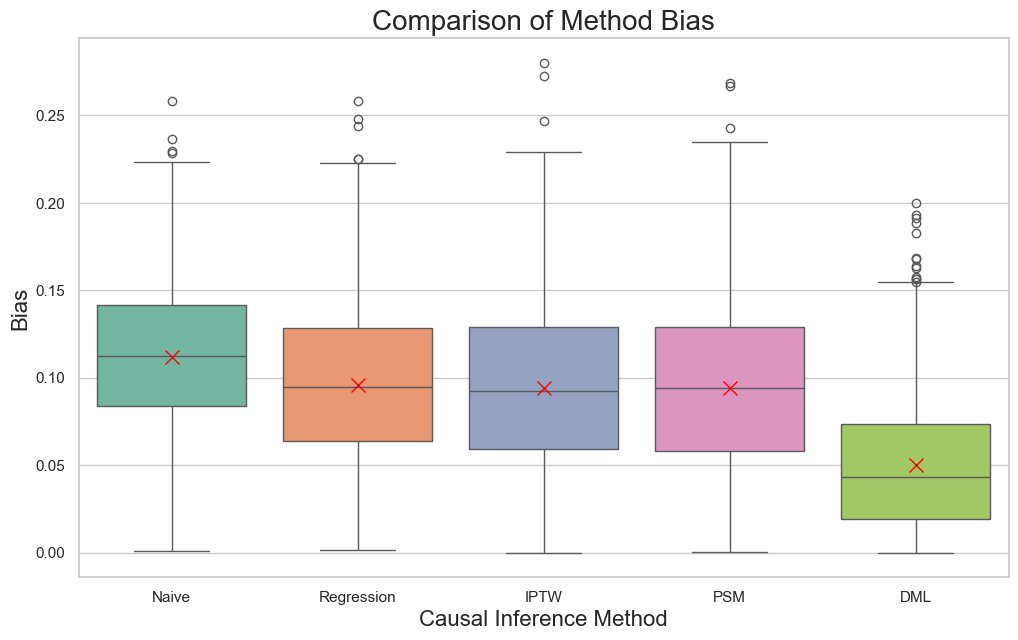

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# 3. Create the boxplot
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Optional: Add 'inner="points"' or 'showmeans=True' for more detail
ax = sns.boxplot(x='method', y='bias', data=df, palette='Set2',
    showmeans=True,meanprops={
        "marker": "x",
        "markeredgecolor": "red",
        "markersize": "10"
    })

# 4. Add formatting
plt.title('Comparison of Method Bias', fontsize=20)
plt.xlabel('Causal Inference Method', fontsize=16)
plt.ylabel('Bias', fontsize=16)
plt.show()